In [1]:
!nvidia-smi

Thu Nov 12 03:54:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   54C    P0   189W / 300W |  26702MiB / 32480MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   34C    P0    65W / 300W |   5299MiB / 32480MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
        

In [20]:
import subprocess
import os


# Paths
EXP_PATH = '/home/ubuntu/lxmert/' #os.getcwd() 
SRC_PATH = os.path.join(EXP_PATH, 'src/run_pretraining.py')
TASK_NAME = 'masked_literal_prediction'

######################
RUN_NAME = 'BSS_TEST'
######################

TRAINING_CONFIG = {
    "model_type":"lxmert",
    "config_name":os.path.join(EXP_PATH,"config/config_transe_visual.json"),
    "tokenizer_name":"bert-base-uncased",
    "do_train": True,
    "evaluate_during_training": True,
    "do_eval": True,
    "prediction_loss_only":False,
    "overwrite_output_dir":True,
    "mlm_probability": 0.15,
    "block_size": 512,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 8,
    "learning_rate": 5e-4,
    "num_train_epochs": 50,
    "logging_steps": int(642/20),
    "save_steps": int(642/5),
    "eval_steps": int(642/5),
    "eval_criterion" :"lang_acc,kg_acc",
    "train_data_file":os.path.join(EXP_PATH,"data/{}/train".format(TASK_NAME)),
    "train_data_files":None, # add
    "eval_data_file": os.path.join(EXP_PATH,"data/{}/valid".format(TASK_NAME)),
    #"test_data_file": os.path.join(EXP_PATH, "data/{}/test".format(TASK_NAME)),
    "run_name":RUN_NAME,
    "output_dir":os.path.join(EXP_PATH,"pretrained_models/{}".format(RUN_NAME)),
    "cache_dir":None,
    "model_name_or_path":None
}

TRAINING_CONFIG_LIST = list()
for (k,v) in list(TRAINING_CONFIG.items()):
    if (isinstance(v, bool)):
        if v:
            TRAINING_CONFIG_LIST.append("--{}".format(k))
    else:
        TRAINING_CONFIG_LIST.append("--{}={}".format(k,v))

In [21]:
TRAINING_CONFIG, TRAINING_CONFIG_LIST

({'model_type': 'lxmert',
  'config_name': '/home/ubuntu/lxmert/config/config_transe_visual.json',
  'tokenizer_name': 'bert-base-uncased',
  'do_train': True,
  'evaluate_during_training': True,
  'do_eval': True,
  'prediction_loss_only': False,
  'overwrite_output_dir': True,
  'mlm_probability': 0.15,
  'block_size': 512,
  'per_device_train_batch_size': 32,
  'per_device_eval_batch_size': 8,
  'learning_rate': 0.0005,
  'num_train_epochs': 50,
  'logging_steps': 32,
  'save_steps': 128,
  'eval_steps': 128,
  'eval_criterion': 'lang_acc,kg_acc',
  'train_data_file': '/home/ubuntu/lxmert/data/masked_literal_prediction/train',
  'train_data_files': None,
  'eval_data_file': '/home/ubuntu/lxmert/data/masked_literal_prediction/valid',
  'run_name': 'BSS_TEST',
  'output_dir': '/home/ubuntu/lxmert/pretrained_models/BSS_TEST',
  'cache_dir': None,
  'model_name_or_path': None},
 ['--model_type=lxmert',
  '--config_name=/home/ubuntu/lxmert/config/config_transe_visual.json',
  '--tokenize

---

<br/>

`run_pretraining.py`

<br/>

---

In [22]:
import sys
sys.path.append('/home/ubuntu/lxmert/src')

In [23]:
from model import LxmertForKGTokPredAndMaskedLM
from utils.dataset import get_dataset
from utils.data_collator import NodeMasking_DataCollator, NodeClassification_DataCollator, LiteralRegression_DataCollator

# From Huggingface transformers package
from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    LxmertConfig,
    LxmertTokenizer,
    PreTrainedTokenizer,
    # Trainer,
    set_seed,
)

# from utils.parameters import parser
# model_args, data_args, training_args = parser.parse_args_into_dataclasses()

import easydict
args = easydict.EasyDict(TRAINING_CONFIG)

In [24]:
# set_seed(args.seed)

In [25]:
args.config_name

'/home/ubuntu/lxmert/config/config_transe_visual.json'

In [27]:
if args.config_name:
    config = LxmertConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
# elif model_args.model_name_or_path:
#     config = LxmertConfig.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
# else:
#     config = CONFIG_MAPPING[args.model_type]()
#     logger.warning("You are instantiating a new config instance from scratch.")

In [28]:
args.tokenizer_name

'bert-base-uncased'

In [29]:
if args.tokenizer_name:
    tokenizer = LxmertTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
# elif model_args.model_name_or_path:
#     tokenizer = LxmertTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
# else:
#     raise ValueError(
#         "You are instantiating a new tokenizer from scratch. This is not supported, but you can do it from another script, save it,"
#         "and load it from here, using --tokenizer_name"
#     )

In [30]:
# if args.model_name_or_path: # False
#     model = LxmertForKGTokPredAndMaskedLM.from_pretrained(
#         args.model_name_or_path,
#         from_tf=bool(".ckpt" in args.model_name_or_path), # False
#         config=config,
#         cache_dir=args.cache_dir, # no cache_dir
#     )
# else:
#     logger.info("Training new model from scratch")
model = LxmertForKGTokPredAndMaskedLM(config)

In [41]:
# config

In [32]:
# Get datasets
train_dataset = (
    get_dataset(args,
                tokenizer=tokenizer,
                kg_pad=config.kg_special_token_ids["PAD"]) if args.do_train else None
)
eval_dataset = (
    get_dataset(args,
                tokenizer=tokenizer,
                kg_pad=config.kg_special_token_ids["PAD"], evaluate=True) if args.do_eval else None
)
# test_dataset = (
#     get_dataset(data_args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], test=True)
#     if training_args.do_eval
#     else None
# )
data_collator = NodeClassification_DataCollator(tokenizer=tokenizer,
                                                kg_special_token_ids=config.kg_special_token_ids,
                                                kg_size = config.vocab_size['kg'])

In [33]:
# args.do_train, args.do_eval
# config.kg_special_token_ids, config.vocab_size
# !wandb login

In [34]:
from utils.training_args import TrainingArguments

train_args = TrainingArguments(output_dir='BSS_TEST',
    do_train=True,
    do_eval=False,
    local_rank=-1,
    per_device_train_batch_size=1,  
    learning_rate=1e-3,
    num_train_epochs=1,
    eval_criterion='lang_acc,kg_acc')

In [43]:
# train_args.to_dict()

In [44]:
from trainer import Trainer

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

wandb: wandb version 0.10.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [45]:
# Training
# if train_args_dict.do_train:
model_path = (
    train_args_dict.model_name_or_path
    if args.model_name_or_path is not None and os.path.isdir(args.model_name_or_path)
    else None
)

In [46]:
temp_train_data_loader = trainer.get_train_dataloader()
trainer.num_examples(temp_train_data_loader)

20534

In [47]:
temp_input_data = next(iter(temp_train_data_loader))

/home/ubuntu/lxmert/src/utils/data_collator.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probability_matrix.masked_fill_(torch.tensor(entity_mask, dtype=torch.bool), value=0.0)
/home/ubuntu/lxmert/src/utils/data_collator.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_mask.masked_fill_(torch.tensor(entity_mask, dtype=torch.bool), value=False)


In [48]:
temp_input_data.keys()

dict_keys(['lang_input_ids', 'kg_input_ids', 'lang_attention_mask', 'kg_attention_mask', 'kg_label', 'token_type_ids', 'kg_label_mask', 'lm_label'])

In [49]:
temp_input_data['lang_input_ids'].shape

torch.Size([1, 512])

In [50]:
temp_input_data['kg_input_ids'].shape

torch.Size([1, 170])

In [51]:
temp_input_data['lang_attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [52]:
temp_input_data['kg_attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])

In [53]:
temp_input_data['kg_label']

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100,  427,  747,  869,
         2918, 2646, 2759, 2591, 2877,  986, 1596, 1909, 2789,  200, 1288, 1408,
         2168, 2294, 3066, 1267, 2678, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -

In [54]:
temp_input_data['kg_label_mask']

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [55]:
temp_input_data['lm_label']

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 23951,  -100,
          -100,  2891,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [56]:
trainer.training_step(model, temp_input_data)

(18.47144317626953,
 {'lm_loss': 10.283180236816406, 'kg_loss': 8.188261985778809})

In [57]:
temp_output_data = model(**temp_input_data, output_attentions=True, return_dict=True)

In [58]:
model.config.output_attentions

False

In [59]:
temp_output_data.keys()

odict_keys(['loss', 'loss_dict', 'lang_prediction_logits', 'kg_prediction_logits', 'cross_relationship_score', 'language_attentions', 'kg_attentions', 'cross_encoder_attentions'])

In [60]:
len(temp_output_data['cross_encoder_attentions'])

5

In [61]:
temp_output_data['cross_encoder_attentions'][-1].shape

torch.Size([1, 8, 512, 170])

In [62]:
temp_output_data['cross_encoder_attentions'][-1][0, 0, :, :].shape

torch.Size([512, 170])

In [63]:
temp_input_data.keys()

dict_keys(['lang_input_ids', 'kg_input_ids', 'lang_attention_mask', 'kg_attention_mask', 'kg_label', 'token_type_ids', 'kg_label_mask', 'lm_label'])

In [64]:
temp = temp_input_data['lang_input_ids'].cpu().squeeze()
temp_len = len(temp[:temp.nonzero().shape[0]])
temp_len

/home/ubuntu/anaconda3/envs/kg_text/lib/python3.7/site-packages/ipykernel/__main__.py:2: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  from ipykernel import kernelapp as app


21

In [65]:
temp2 = temp_input_data['kg_input_ids'].cpu().squeeze()
temp2_len = len(temp2[:temp2.nonzero().shape[0]])
temp2_len

41

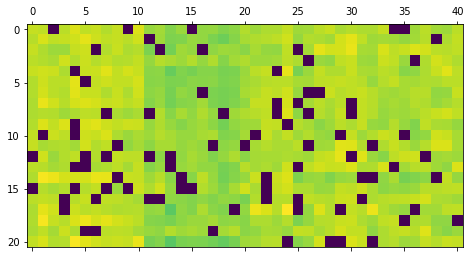

In [66]:
import matplotlib.pyplot as plt

head_idx=0

plt.matshow(
temp_output_data['cross_encoder_attentions'][-1][0,head_idx,
                                                 :temp_len,:temp2_len].cpu().detach().numpy()
)

In [68]:
temp_output_data['language_attentions'][-1].shape

torch.Size([1, 8, 512, 512])

In [69]:
temp_input_data['lang_input_ids'].shape

torch.Size([1, 512])